# 1. Data Augmentation Layer

Les permutations aléatoires de SMILES et les tautomères ne changent pas les propriétés chimiques fondamentales de la molécule, mais il est important de comprendre les différences entre les deux :


### 1. Permutations aléatoires de SMILES :

- Les permutations aléatoires de SMILES génèrent différentes représentations linéaires de la même molécule. Elles ne changent pas la structure chimique ou les propriétés chimiques de la molécule. Elles sont simplement des réarrangements de la notation SMILES.
- source : https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html#rdkit.Chem.rdmolfiles.MolToSmiles
  
### 2. Tautomères :

- Les tautomères sont des isomères de la même molécule qui diffèrent par la position des protons et des doubles liaisons. Bien que les tautomères aient les mêmes atomes et la même formule moléculaire, ils peuvent avoir des propriétés chimiques légèrement différentes en raison de la répartition différente des électrons.
- source :https://en.wikipedia.org/wiki/Tautomer

### 3. Remplacement par un groupe chimique de la meme classe fonctionnel

Remplacer un groupe fonctionnel par un autre de la même classe chimique. Par exemple, remplacer un groupe hydroxyle par un groupe méthoxy tout en conservant les propriétés de la molécule.

In [10]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize
import random

In [14]:
df = pd.read_csv('C:/Users/quent/Data Science/Mines/Projet/Processed_Anti_Inflammatory_Compounds.csv')
print(df.head())
# List to store new rows
print(len(df))


                                           isosmiles      mw  xlogp  \
0                                      CCCCCCCC(=O)O  144.21    3.0   
1  C1=CC(=CC=C1C(=O)N[C@@H](CCC(=O)O)C(=O)O)NCC2=...  441.40   -1.1   
2                                            CC(=O)C   58.08   -0.1   
3                               CC(=CCC/C(=C/CO)/C)C  154.25    2.9   
4                                     C1=COC(=C1)C=O   96.08    0.4   

   polararea  rotbonds  hbonddonor  hbondacc  charge  anti_inflammatory  
0       37.3         6           1         2       0                  0  
1      209.0         9           6        10       0                  0  
2       17.1         0           0         1       0                  0  
3       20.2         4           1         1       0                  0  
4       30.2         1           0         2       0                  0  
1883


## 1.1 Permutation de la molécule

In [19]:
def augment_smiles(smiles, num_augmentations=4):
    mol = Chem.MolFromSmiles(smiles)
    augmented_smiles = set()
    
    for _ in range(num_augmentations):
        # Generate a random permutation of the SMILES
        random_smiles = Chem.MolToSmiles(mol, doRandom=True)
        augmented_smiles.add(random_smiles)
    
    return list(augmented_smiles)

# Example usage
original_smiles = "CCCCCCCC(=O)O"
augmented_smiles_list = augment_smiles(original_smiles)
print(augmented_smiles_list)


['C(CCCC(O)=O)CCC', 'C(CC)CCCCC(O)=O', 'C(CCCCC(O)=O)CC', 'C(CCCCCCC)(=O)O']


# 1.2 Tautomérisation


In [36]:
import os
import sys
def suppress_rdkit_warnings():
    from rdkit import rdBase
    rdBase.DisableLog('rdApp.error')
    rdBase.DisableLog('rdApp.warning')

def generate_tautomers(smiles, max_tautomers=2):
    mol = Chem.MolFromSmiles(smiles)
    enumerator = rdMolStandardize.TautomerEnumerator()
    tautomers = enumerator.Enumerate(mol)
    
    tautomers_smiles = []
    for tautomer in tautomers:
        tautomers_smiles.append(Chem.MolToSmiles(tautomer))
        if len(tautomers_smiles) >= max_tautomers:
            break
    
    return tautomers_smiles

# Suppress RDKit warnings
suppress_rdkit_warnings()

# Example usage
original_smiles = "C1=CC(=CC=C1C(=O)N[C@@H](CCC(=O)O)C(=O)O)NCC2=CN=C3C(=N2)C(=O)NC(=N3)N"
tautomers_list = generate_tautomers(original_smiles, max_tautomers=2)
print(tautomers_list)
print(len(tautomers_list))

['N=c1[nH]c(=O)c2nc(CN=C3C=CC(=C(O)NC(CC=C(O)O)=C(O)O)C=C3)cnc2[nH]1', 'N=c1[nH]c(=O)c2nc(CN=C3C=CC(=C(O)NC(CC=C(O)O)C(=O)O)C=C3)cnc2[nH]1']
2


# 1.3 Remplacement par un groupe fonctionnel de la meme famille

ça ne marche pas c'était juste un test

In [31]:
from rdkit import Chem
from rdkit.Chem import AllChem

def replace_functional_groups(smiles, replacements, max_replacements=10):
    mol = Chem.MolFromSmiles(smiles)
    augmented_smiles = set()
    
    for smarts, replacement in replacements:
        try:
            rxn = AllChem.ReactionFromSmarts(f'{smarts}>>{replacement}')
            products = rxn.RunReactants((mol,))
            for product_set in products:
                for product in product_set:
                    augmented_smiles.add(Chem.MolToSmiles(product))
                    if len(augmented_smiles) >= max_replacements:
                        return list(augmented_smiles)
        except Exception as e:
            print(f"Error with SMARTS {smarts}>>{replacement}: {e}")
    
    return list(augmented_smiles)

# Define functional group replacements (example)
replacements = [
    ('[OH:1]', '[OCH3:1]'),  # Replace hydroxyl with methoxy
    ('[NH2:1]', '[NHCH3:1]'),  # Replace amine with methylamine
    ('[C(=O)OH:1]', '[C(=O)OCH3:1]')  # Replace carboxyl with ester
]

# Test the function with example SMILES
test_smiles = [
    "CC(=O)O",  # Acetic acid
    "C1=CC(=O)NC=C1",  # Pyridine-2-one
    "CC(C)O",  # Isopropanol
]

for smiles in test_smiles:
    print(f"Original SMILES: {smiles}")
    replaced_smiles = replace_functional_groups(smiles, replacements)
    print(f"Replaced SMILES: {replaced_smiles}\n")

# Example usage
original_smiles = "CC(=O)O"
replaced_smiles_list = replace_functional_groups(original_smiles, replacements)
print(replaced_smiles_list)

Original SMILES: CC(=O)O
Error with SMARTS [C(=O)OH:1]>>[C(=O)OCH3:1]: ChemicalReactionParserException: Problems constructing reactant from SMARTS: [C(=O)OH:1]
Replaced SMILES: ['CC(=O)[OH3]']

Original SMILES: C1=CC(=O)NC=C1
Error with SMARTS [C(=O)OH:1]>>[C(=O)OCH3:1]: ChemicalReactionParserException: Problems constructing reactant from SMARTS: [C(=O)OH:1]
Replaced SMILES: []

Original SMILES: CC(C)O
Error with SMARTS [C(=O)OH:1]>>[C(=O)OCH3:1]: ChemicalReactionParserException: Problems constructing reactant from SMARTS: [C(=O)OH:1]
Replaced SMILES: ['CC(C)[OH3]']

Error with SMARTS [C(=O)OH:1]>>[C(=O)OCH3:1]: ChemicalReactionParserException: Problems constructing reactant from SMARTS: [C(=O)OH:1]
['CC(=O)[OH3]']


[18:49:03] atom 0 in product 0 has multiple H count specifications.
[18:49:03] SMARTS Parse Error: syntax error while parsing: [C(=O)OH:1]
[18:49:03] SMARTS Parse Error: Failed parsing SMARTS '[C(=O)OH:1]' for input: '[C(=O)OH:1]'
[18:49:03] atom 0 in product 0 has multiple H count specifications.
[18:49:03] SMARTS Parse Error: syntax error while parsing: [C(=O)OH:1]
[18:49:03] SMARTS Parse Error: Failed parsing SMARTS '[C(=O)OH:1]' for input: '[C(=O)OH:1]'
[18:49:03] atom 0 in product 0 has multiple H count specifications.
[18:49:03] SMARTS Parse Error: syntax error while parsing: [C(=O)OH:1]
[18:49:03] SMARTS Parse Error: Failed parsing SMARTS '[C(=O)OH:1]' for input: '[C(=O)OH:1]'
[18:49:03] atom 0 in product 0 has multiple H count specifications.
[18:49:03] SMARTS Parse Error: syntax error while parsing: [C(=O)OH:1]
[18:49:03] SMARTS Parse Error: Failed parsing SMARTS '[C(=O)OH:1]' for input: '[C(=O)OH:1]'


# Fonction d'assemblage des différentes fonctions (tautomères + permutations)

In [37]:
def augment_data(df, generate_tautomers_flag=True, generate_permutations_flag=True, max_tautomers=10, num_augmentations=10):
    new_rows = []

    # Process each row in the DataFrame
    for index, row in df.iterrows():
        if row['anti_inflammatory'] == 1:
            smiles = row['isosmiles']
            
            if generate_tautomers_flag:
                tautomers = generate_tautomers(smiles, max_tautomers=5)
                for tautomer in tautomers:
                    new_row = row.copy()
                    new_row['isosmiles'] = tautomer
                    new_rows.append(new_row)
            
            if generate_permutations_flag:
                augmented_smiles = augment_smiles(smiles, num_augmentations)
                for aug_smiles in augmented_smiles:
                    new_row = row.copy()
                    new_row['isosmiles'] = aug_smiles
                    new_rows.append(new_row)
     # Create a new DataFrame with the original and new rows
    new_df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
    return new_df

# Suppress RDKit warnings
suppress_rdkit_warnings()
# Create a new DataFrame with the original and new rows
new_df_all = augment_data(df, generate_tautomers_flag=True, generate_permutations_flag=True, max_tautomers=10, num_augmentations=10)
##new_df_permut = augment_data(df, generate_tautomers_flag=False, generate_permutations_flag=True, max_tautomers=10, num_augmentations=10)
print(new_df_all.head())
#print(len(new_df))

                                           isosmiles      mw  xlogp  \
0                                      CCCCCCCC(=O)O  144.21    3.0   
1  C1=CC(=CC=C1C(=O)N[C@@H](CCC(=O)O)C(=O)O)NCC2=...  441.40   -1.1   
2                                            CC(=O)C   58.08   -0.1   
3                               CC(=CCC/C(=C/CO)/C)C  154.25    2.9   
4                                     C1=COC(=C1)C=O   96.08    0.4   

   polararea  rotbonds  hbonddonor  hbondacc  charge  anti_inflammatory  
0       37.3         6           1         2       0                  0  
1      209.0         9           6        10       0                  0  
2       17.1         0           0         1       0                  0  
3       20.2         4           1         1       0                  0  
4       30.2         1           0         2       0                  0  


In [33]:
print(len(new_df_all))

14333


# Core

In [46]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from rdkit.ML.Descriptors import MoleculeDescriptors

smiles = "CCO"  # Exemple de SMILES
mol = Chem.MolFromSmiles(smiles)
descriptor_names = [desc[0] for desc in Descriptors._descList]
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
descriptors = calculator.CalcDescriptors(mol)
descriptors_dict = dict(zip(descriptor_names, descriptors))
print("Descripteurs moléculaires :", descriptors_dict)  # Afficher les descripteurs moléculaires

Descripteurs moléculaires : {'MaxAbsEStateIndex': 7.569444444444445, 'MaxEStateIndex': 7.569444444444445, 'MinAbsEStateIndex': 0.25, 'MinEStateIndex': 0.25, 'qed': 0.4068079656553945, 'SPS': 6.0, 'MolWt': 46.069, 'HeavyAtomMolWt': 40.021, 'ExactMolWt': 46.041864812, 'NumValenceElectrons': 20, 'NumRadicalElectrons': 0, 'MaxPartialCharge': 0.04022058174908642, 'MinPartialCharge': -0.3966637147812598, 'MaxAbsPartialCharge': 0.3966637147812598, 'MinAbsPartialCharge': 0.04022058174908642, 'FpDensityMorgan1': 2.0, 'FpDensityMorgan2': 2.0, 'FpDensityMorgan3': 2.0, 'BCUT2D_MWHI': 16.248991329327914, 'BCUT2D_MWLOW': 10.908168035086371, 'BCUT2D_CHGHI': 1.3402935186707783, 'BCUT2D_CHGLO': -1.52235869276019, 'BCUT2D_LOGPHI': 1.2962426382141046, 'BCUT2D_LOGPLOW': -1.5683635470355741, 'BCUT2D_MRHI': 3.835802335589486, 'BCUT2D_MRLOW': 0.3184056131739115, 'AvgIpc': 0.9182958340544894, 'BalabanJ': 1.6329931618554523, 'BertzCT': 2.7548875021634682, 'Chi0': 2.7071067811865475, 'Chi0n': 2.1543203766865053

[20:15:05] DEPRECATION WARNING: please use MorganGenerator
[20:15:05] DEPRECATION WARNING: please use MorganGenerator
[20:15:05] DEPRECATION WARNING: please use MorganGenerator


In [47]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

def predict_properties(smiles_list):
    descriptor_names = [desc[0] for desc in Descriptors._descList]
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
    
    predictions = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
        descriptors = calculator.CalcDescriptors(mol)
        
        # Hypothetical rules for prediction
        mw = descriptors[descriptor_names.index('MolWt')]
        logp = descriptors[descriptor_names.index('MolLogP')]
        
        if mw < 300 and logp < 3:
            prediction = 'Antioxidant'
        else:
            prediction = 'Anti-inflammatory'
        
        predictions.append((smiles, prediction))
    
    return predictions

# Example SMILES list
smiles_list = ["CCO", "CC(=O)O", "CCN"]

# Predict properties
predictions = predict_properties(smiles_list)

# Print predictions
for smiles, prediction in predictions:
    print(f"SMILES: {smiles}, Prediction: {prediction}")

SMILES: CCO, Prediction: Antioxidant
SMILES: CC(=O)O, Prediction: Antioxidant
SMILES: CCN, Prediction: Antioxidant


[20:17:07] DEPRECATION WARNING: please use MorganGenerator
[20:17:07] DEPRECATION WARNING: please use MorganGenerator
[20:17:07] DEPRECATION WARNING: please use MorganGenerator
[20:17:07] DEPRECATION WARNING: please use MorganGenerator
[20:17:07] DEPRECATION WARNING: please use MorganGenerator
[20:17:07] DEPRECATION WARNING: please use MorganGenerator
[20:17:07] DEPRECATION WARNING: please use MorganGenerator
[20:17:07] DEPRECATION WARNING: please use MorganGenerator
[20:17:07] DEPRECATION WARNING: please use MorganGenerator


In [ ]:
import pickle
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

# Load the pre-trained model
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

def predict_properties(smiles_list):
    descriptor_names = [desc[0] for desc in Descriptors._descList]
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
    
    predictions = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
        descriptors = calculator.CalcDescriptors(mol)
        prediction = model.predict([descriptors])
        predictions.append((smiles, prediction[0]))
    
    return predictions

# Example SMILES list
smiles_list = ["CCO", "CC(=O)O", "CCN"]

# Predict properties
predictions = predict_properties(smiles_list)

# Print predictions
for smiles, prediction in predictions:
    print(f"SMILES: {smiles}, Prediction: {'Antioxidant' if prediction == 1 else 'Anti-inflammatory'}")

# PCA

Variance expliquée par chaque composante : [8.95097890e-01 6.73211630e-02 3.75809475e-02 2.41859086e-34]
Variance expliquée cumulée : [0.89509789 0.96241905 1.         1.        ]


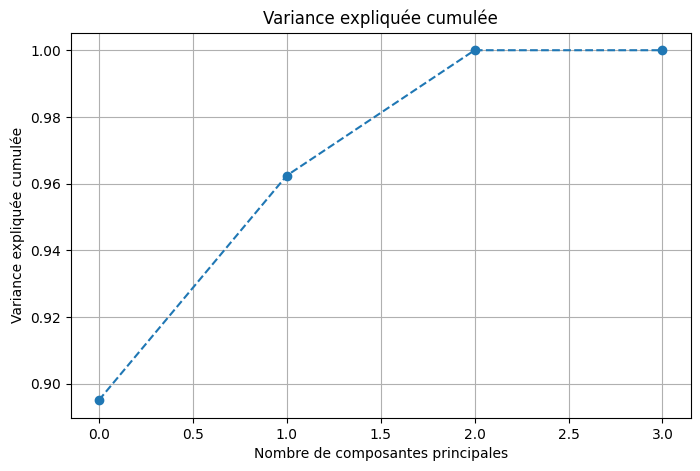

Contributions des variables aux composantes principales :
           mw     xlogp  polararea  rotbonds  hbonddonor  hbondacc
PC1  0.363131  0.383588   0.428047  0.422819    0.424522  0.422819
PC2  0.734009 -0.607360  -0.002232  0.097410   -0.270854  0.097410
PC3 -0.573594 -0.519135   0.266188  0.399757   -0.104981  0.399757
PC4  0.007239  0.177603   0.773102 -0.206983   -0.533885 -0.206983


In [9]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Exemple de dataset
data = {
    'mw': [120, 150, 200, 300],
    'xlogp': [2.5, 3.0, 1.8, 4.1],
    'polararea': [50, 75, 60, 90],
    'rotbonds': [2, 4, 3, 5],
    'hbonddonor': [1, 2, 1, 3],
    'hbondacc': [3, 5, 4, 6],
    'anti_ox': [1, 0, 1, 0],
    'anti_inf': [0, 1, 0, 1]
}

# Chargement des données dans un DataFrame
df = pd.DataFrame(data)

# Variables explicatives (features) et cibles
features = ['mw', 'xlogp', 'polararea', 'rotbonds', 'hbonddonor', 'hbondacc']
target = ['anti_ox', 'anti_inf']

X = df[features]
y = df[target]

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Application de la PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée par chaque composante principale
explained_variance = pca.explained_variance_ratio_

# Affichage des résultats
print("Variance expliquée par chaque composante :", explained_variance)
print("Variance expliquée cumulée :", np.cumsum(explained_variance))

# Visualisation de la variance expliquée
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
plt.title('Variance expliquée cumulée')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.grid()
plt.show()

# Ajuster la forme du DataFrame en fonction du nombre de composantes
n_components = X_pca.shape[1]  # Le nombre de composantes principales
components_df = pd.DataFrame(
    pca.components_, 
    columns=features, 
    index=[f'PC{i+1}' for i in range(n_components)]
)

print("Contributions des variables aux composantes principales :")
print(components_df)

